In [ ]:
import tensorflow as tf

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print("TPU initialized")

tf.tpu.experimental.initialize_tpu_system(tpu)
print("TPU system initialized")

tpu_strategy = tf.distribute.TPUStrategy(tpu)
print("TPU strategy initialized")

E0000 00:00:1728677573.447591      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1011 20:12:53.456352915      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1011 20:12:53.456368643      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1011 20:12:53.456372515      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1011 20:12:53.456375386      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1011 20:12:53.456378252      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

TPU initialized
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728677585.858588      13 service.cc:145] XLA service 0x5687ca4a2360 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728677585.858644      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728677585.858648      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728677585.858651      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728677585.858654      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728677585.858657      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728677585.858659      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728677585.858662      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728677585.858665      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
TPU system initialized
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/dev

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
Imagenes = np.load('/kaggle/input/Imagenes Lentes/ImagenesTotales.npy')

In [ ]:
Labels = np.load('/kaggle/input/Imagenes Lentes/Labels.npy')

Imagen número 698
Imagen sin efecto de lente.


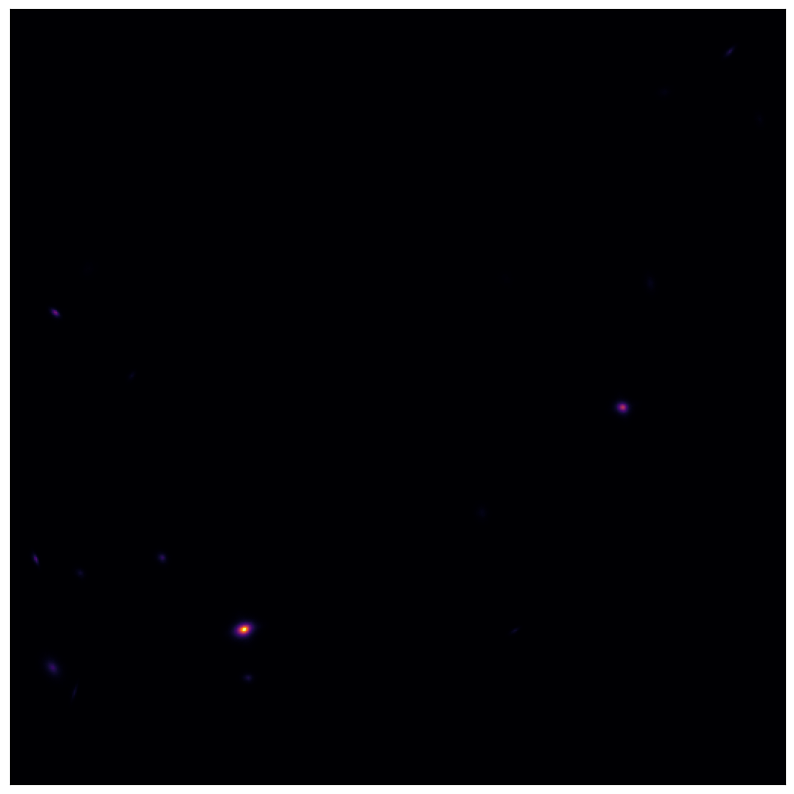

In [ ]:
import random
i = int(np.random.rand(1)*5500)
print(f'Imagen número {i}')

if i/500 < 4: print('Imagen sin efecto de lente.')
else: print('Imagen con efecto de lente.')

plt.figure(figsize = (10,12))
plt.imshow(Imagenes[i], origin = 'lower', cmap = 'inferno')
plt.xticks([])
plt.yticks([])
plt.show()

#1765 #3238 5234 4020 5435 70 2109 5102 393 1060 1700 1398 4240 2466 1765 5014 4235 938 1716

In [ ]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

images_train, images_test, targets_train, targets_test = model_selection.train_test_split(Imagenes, Labels, test_size = 0.2)

targets_train = to_categorical(targets_train, num_classes = 2)
targets_test = to_categorical(targets_test, num_classes = 2)

images_train = np.expand_dims(images_train, axis = -1)
images_test = np.expand_dims(images_test, axis = -1)

images_train.shape

(4400, 512, 512, 1)

In [ ]:
from tensorflow.keras import models, layers

with tpu_strategy.scope():
    input_shape = (512, 512, 1)

    model = models.Sequential([
        layers.Input(shape = input_shape),
        layers.Conv2D(64, (5, 5), activation = 'relu', padding = 'valid'),
        layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'valid'),
        layers.MaxPooling2D((4, 4)),
        layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'),
        layers.Conv2D(16, (5, 5), activation = 'relu', padding = 'valid'),
        layers.MaxPooling2D((4, 4)),
        layers.Flatten(),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(2, activation = 'softmax'),
    ])

    model.summary()

    optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.0001, use_ema = True)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

I0000 00:00:1728677757.461968      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 508, 508, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 506, 506, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 120, 120, 16)   │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       230,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,514 (1.15 MB)

 Trainable params: 300,514 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    images_train, targets_train,
    validation_data = (images_test, targets_test),
    epochs = 50,
    batch_size = 16*tpu_strategy.num_replicas_in_sync,
    verbose = 1
)

Epoch 1/50


2024-09-23 23:24:09.957153: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1727133850.466882     809 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8c2c9b19bccdcf7d:0:0), session_name()


 1/35 ━━━━━━━━━━━━━━━━━━━━ 5:24 10s/step - accuracy: 0.5000 - loss: 4.5140

I0000 00:00:1727133857.259992     809 tpu_compile_op_common.cc:245] Compilation of 8c2c9b19bccdcf7d:0:0 with session name  took 6.793060272s and succeeded
I0000 00:00:1727133857.266732     809 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8c2c9b19bccdcf7d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17920435354495937869", property.function_library_fingerprint = 9688538784067359917, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,512,512,1,;16,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1727133857.266761     809 tpu_compilation_cache_interface.cc:541] After adding entry for key

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6106 - loss: 2.4162

I0000 00:00:1727133863.470385     804 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c21d3406065a26c5:0:0), session_name()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.6124 - loss: 2.3935

I0000 00:00:1727133871.081533     804 tpu_compile_op_common.cc:245] Compilation of c21d3406065a26c5:0:0 with session name  took 7.611109201s and succeeded
I0000 00:00:1727133871.089640     804 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c21d3406065a26c5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17920435354495937869", property.function_library_fingerprint = 9688538784067359917, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "6,512,512,1,;6,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1727133871.089676     804 tpu_compilation_cache_interface.cc:541] After adding entry for key c

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 911ms/step - accuracy: 0.6140 - loss: 2.3721 - val_accuracy: 0.7609 - val_loss: 0.8565
Epoch 2/50


I0000 00:00:1727133888.299375     775 tpu_compile_op_common.cc:245] Compilation of b2eea6f720d8c771:0:0 with session name  took 5.769667642s and succeeded
I0000 00:00:1727133888.301872     775 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b2eea6f720d8c771:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16590265355310878139", property.function_library_fingerprint = 15946706144193805228, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "10,512,512,1,;10,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1727133888.301897     775 tpu_compilation_cache_interface.cc:541] After adding entry for ke

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.7770 - loss: 0.6268 - val_accuracy: 0.7899 - val_loss: 0.7244
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.8007 - loss: 0.5071 - val_accuracy: 0.7681 - val_loss: 0.7346
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.8422 - loss: 0.4089 - val_accuracy: 0.7826 - val_loss: 0.7742
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.7887 - loss: 0.4841 - val_accuracy: 0.7899 - val_loss: 0.8150
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.8140 - loss: 0.4152 - val_accuracy: 0.7826 - val_loss: 0.8478
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.8366 - loss: 0.4261 - val_accuracy: 0.7826 - val_loss: 0.8306
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - accuracy: 0.8281 - loss: 0.3803 - val_accuracy: 0.7826 - val_loss: 0.8820
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.7820 - loss: 0.4123 - val_accuracy: 0.7899 - val

In [ ]:
test_loss, test_acc = model.evaluate(images_test, targets_test)
print("Test accuracy:", test_acc)

I0000 00:00:1727134370.734120     772 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(285844cdff490ed1:0:0), session_name()


 5/35 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4200 - loss: 3.3885

I0000 00:00:1727134376.521056     772 tpu_compile_op_common.cc:245] Compilation of 285844cdff490ed1:0:0 with session name  took 5.786838359s and succeeded
I0000 00:00:1727134376.523923     772 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(285844cdff490ed1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16590265355310878139", property.function_library_fingerprint = 15946706144193805228, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,512,1,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1727134376.523953     772 tpu_compilation_cache_interface.cc:541] After adding entry for key 

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6567 - loss: 1.7928

I0000 00:00:1727134377.557501     770 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cfc9cfb14d6cee86:0:0), session_name()


35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6632 - loss: 1.7510
Test accuracy: 0.7318840622901917


I0000 00:00:1727134383.721592     770 tpu_compile_op_common.cc:245] Compilation of cfc9cfb14d6cee86:0:0 with session name  took 6.16404042s and succeeded
I0000 00:00:1727134383.724281     770 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cfc9cfb14d6cee86:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16590265355310878139", property.function_library_fingerprint = 15946706144193805228, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,512,1,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1727134383.724306     770 tpu_compilation_cache_interface.cc:541] After adding entry for key c

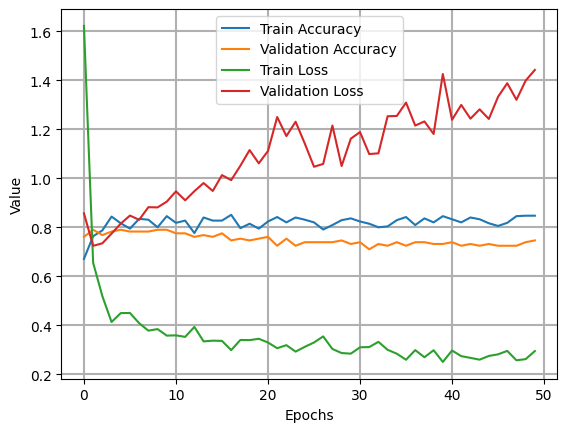

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.grid(linewidth = 1.5)
plt.legend(loc = 'upper center')

plt.savefig('/kaggle/working/CurvasAprendizaje.jpg', format = 'jpg')
plt.show()

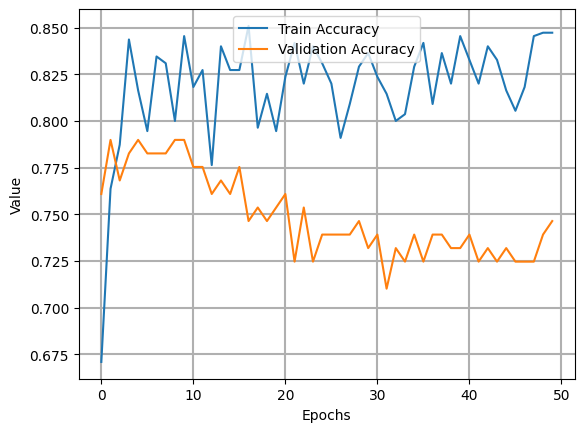

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.grid(linewidth = 1.5)
plt.legend(loc = 'upper center')

plt.savefig('/kaggle/working/CurvasAprendizajeAcc.jpg', format = 'jpg')
plt.show()

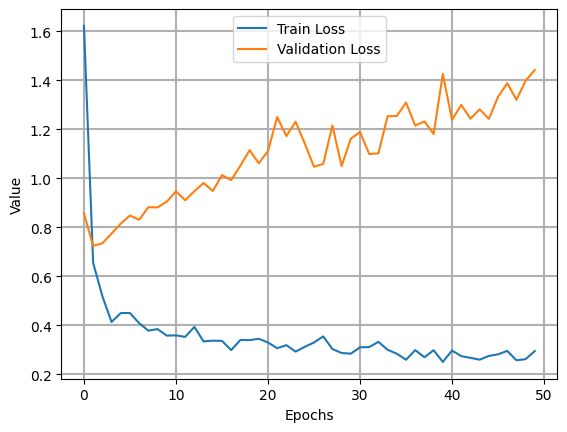

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.grid(linewidth = 1.5)
plt.legend(loc = 'upper center')

plt.savefig('/kaggle/working/CurvasAprendizajeLoss.jpg', format = 'jpg')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/Modelos/modelo74.keras')

In [ ]:
images_train_large, images_test_large, targets_train_large, targets_test_large = model_selection.train_test_split(Imagenes, Labels, test_size = 0.3)

targets_train_large = to_categorical(targets_train_large, num_classes = 2)
targets_test_large = to_categorical(targets_test_large, num_classes = 2)


images_train_large = np.expand_dims(images_train_large, axis = -1)
images_test_large = np.expand_dims(images_test_large, axis = -1)

print("Tamaño del nuevo conjunto de entrenamiento:", images_train_large.shape)
print("Tamaño del nuevo conjunto de prueba:", images_test_large.shape)

Tamaño del nuevo conjunto de entrenamiento: (3850, 512, 512, 1)
Tamaño del nuevo conjunto de prueba: (1650, 512, 512, 1)


52/52 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step


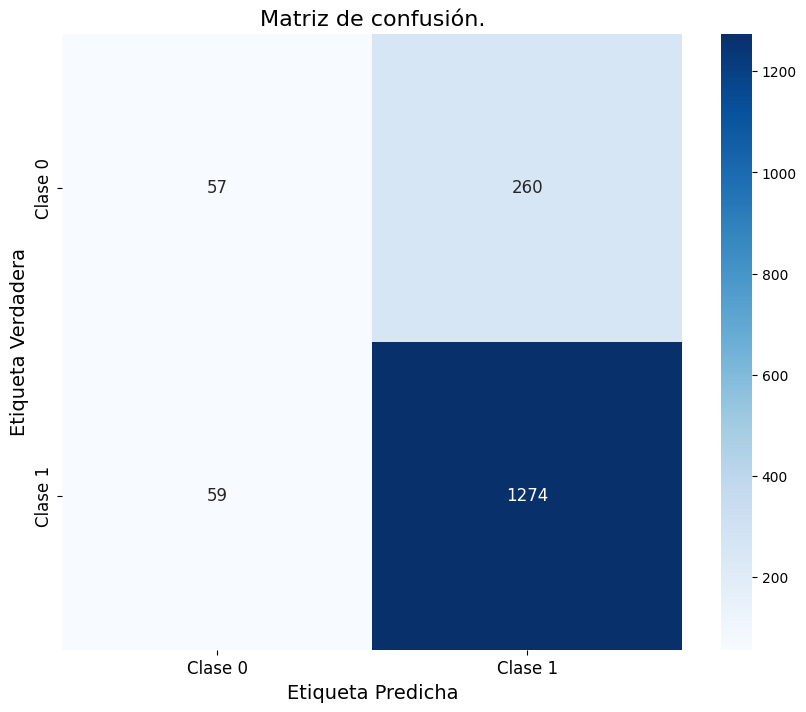

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred = model.predict(images_test_large)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(targets_test_large, axis = 1)


conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize = (10, 8))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = ['Clase 0', 'Clase 1'], yticklabels = ['Clase 0', 'Clase 1'], annot_kws = {"size": 12})

plt.ylabel('Etiqueta Verdadera', fontsize = 14)
plt.xlabel('Etiqueta Predicha', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Matriz de confusión.', fontsize = 16)

plt.savefig('/kaggle/working/MatrizConfusion.jpg', format = 'jpg')
plt.show()

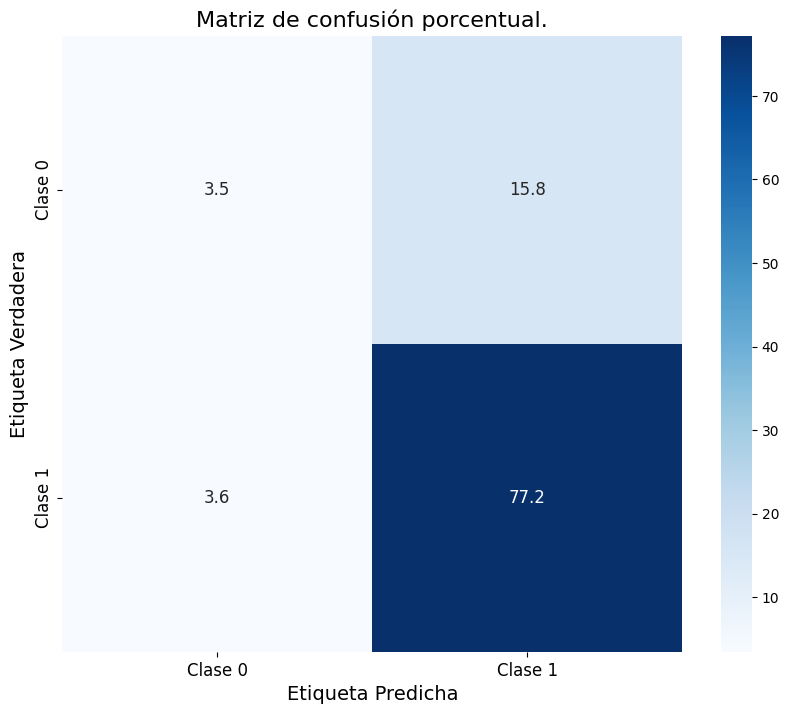

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)


conf_matrix_percent = conf_matrix.astype('float')/conf_matrix.sum()*100
plt.figure(figsize = (10, 8))
sns.heatmap(conf_matrix_percent, annot = True, fmt = ".1f", cmap = "Blues", xticklabels = ['Clase 0', 'Clase 1'], yticklabels = ['Clase 0', 'Clase 1'], annot_kws = {"size": 12})

plt.ylabel('Etiqueta Verdadera', fontsize = 14)
plt.xlabel('Etiqueta Predicha', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Matriz de confusión porcentual.', fontsize = 16)


plt.savefig('/kaggle/working/MatrizConfusionPorcentajes.jpg', format = 'jpg')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

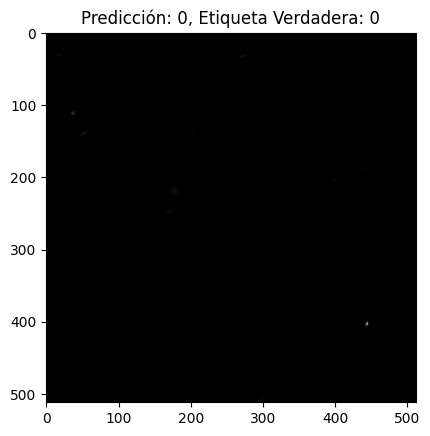

¡Predicción Correcta! (Índice mostrado: 267)
Otras imágenes que cumplen la condición: [365]


In [ ]:
# Encontrar todas las imágenes que tengan una etiqueta específica y una predicción específica.

def show_specific_prediction(model, true_class, predicted_class):
    true_class_indices = [i for i, label in enumerate(targets_test) if np.argmax(label) == true_class]


    matching_indices = []
    for idx in true_class_indices:
        image = images_test[idx]
        pred = model.predict(np.expand_dims(image, axis = 0))
        predicted_label = np.argmax(pred)

        if predicted_label == predicted_class:
            matching_indices.append(idx)

    if matching_indices:  # Mostrar solo una imagen que cumpla ambas condiciones
        selected_idx = matching_indices[0]
        image = images_test[selected_idx]
        true_label = np.argmax(targets_test[selected_idx])

        plt.figure(figsize = (10, 8))
        plt.imshow(image.squeeze(), cmap = 'gray')
        plt.title(f'Predicción: {predicted_class}, Etiqueta Verdadera: {true_class}')
        plt.show()

        print(f"¡Predicción {true_class} correcta! (Índice mostrado: {selected_idx})")
        print(f"Otras imágenes que cumplen la condición: {matching_indices[1:]}")
    else:
        print(f"No se encontraron imágenes con etiqueta verdadera {true_class} y predicción {predicted_class}.")


show_specific_prediction(model, true_class = 0, predicted_class = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
¡Predicción Correcta!
Imagen número 637


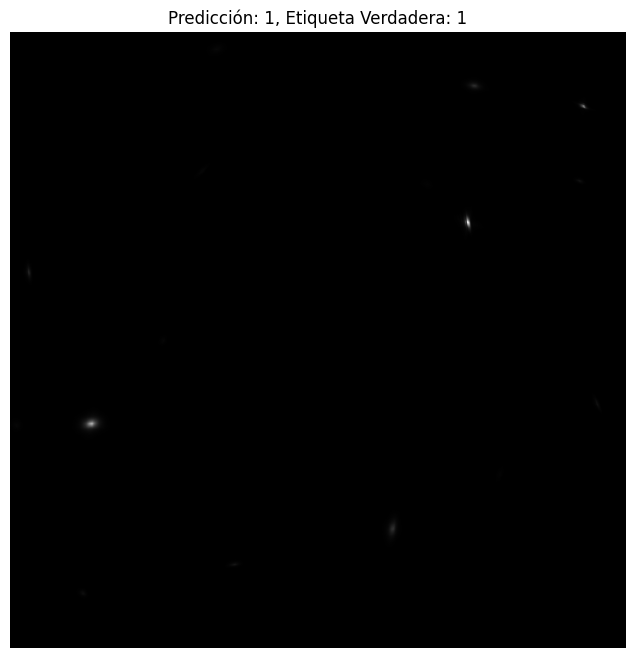

In [ ]:
# Seleccionar una imagen aleatoria del conjunto de test.

def show_random_prediction(model):

    idx = random.randint(0, len(images_test) - 1)
    image = images_test[idx]
    true_label = np.argmax(targets_test[idx])

    pred = model.predict(np.expand_dims(image, axis = 0))
    predicted_label = np.argmax(pred)


    if predicted_label == true_label:
        print("¡Predicción Correcta!")
    else:
        print("Predicción Incorrecta.")

    print('Imagen número', idx)


    plt.figure(figsize = (10, 8))
    plt.imshow(image.squeeze(), cmap = 'gray')
    plt.title(f'Predicción: {predicted_label}, Etiqueta Verdadera: {true_label}')
    plt.axis('off')
    plt.savefig('/kaggle/working/Prediccion.jpg', format = 'jpg')
    plt.show()

show_random_prediction(model)
#1-correcto 23, 364 ,387, 897, 654   #0- correcta 365 267
#0-fallida 976 394 521   #1-fallida 187 752 815